# Question 3

**_Parameter inference._** _Recall the stem cell model from HW1. It is defined by the following set of differential equations:_

$$x'_1 = a_1x_1(1 − x_1 − 0.1x_2 − 0.1x_3) − c_1x_1$$
$$x'_2 = 0.5c_1x_1 − e_1x_2$$
$$x'_3 = e_1x_2 − 0.9x_3$$
$$x'_4 = 0.5c_1x_1 − 0.6x_4$$
$$x'_5 = x_4 − 0.1x_5$$

_where the parameters (a1, c1, e1) lie in the range [0, 3]. Your collaborator has given you some biological data (see attached txt file). How would you test if the model described above is able to describe these data (i.e. the model ﬁts the data)? Briefly discuss different possible strategies for parameter inference. Perform parameter inference on this model in Julia. There are many different ways to this, Turing.jl is recommended, but not required. To report the results, give the predicted posterior values (either characterized by mean, s.d., or full distributions) for (a1,c1,e1). Discuss briefly the marginal posterior distributions identified._

_Hints: 1. Since you know little about the prior values of the parameters, it is probably wise to use relatively uninformative priors. 2. To define the time range and load the data, 50 time points for each of x1, ..., x5, use:_

```
$ time = collect(range(1, stop=50 , length=50))
$ using DelimitedFiles
$ targetdata = readdlm("targetdata.txt", '\t', Float64, '\n')
```


Using the data that our collaborator has provided, we can test whether our stem cell model is actually a good fit for real data.

There are a couple of ways to fit a model to data. I think the most common approach would be to fit a regression; this is a frequentist approach, meaning it doesn’t take in any prior information that could actually be super informative, nor does it provide any information about the distribution that it settles on. A MLE approach has this same caveat — there’s no measure of uncertainty or fit.

Meanwhile, taking a Bayesian approach lets us use posterior distributions and likelihood estimates to better understand and fit the parameters. This is the approach we’re going to take for this problem, using `Turing.jl` and MCMC sampling.

To come up with our priors, we use some pretty basic approaches. We let our variance $\sigma$ just be an inverse gamma distribution (which is pretty commonly used in these sorts of contexts because it’s very flexible), and each of the parameters is sampled uniformly between 0 and 3, as given in the problem. We let our data be modeled by a multivariate normal distribution, which allows for relationships between all the data (as opposed to a regular normal distribution).

Finally, we fit our model to the data and use MCMC to figure out how the parameters get modelled.

From the plots below, see that all our parameters have some sort of peak. For a1, we see a peak just around 2.0 and a slight right skew (so the mean is a bit more than 2). In the context of the stem cell model, we initially set a1 to 0.9, but if we fit to the real data, this value be more than doubled. a1 is the parameter that influences self-renewal, so a 2-fold change seems like it might actually have a big effect on the system.

c1 peaks around 1.08, with a pretty normal distribution with a teeny tiny standard deviation. c1 is the differentiation rate from $x_1$ to $x_2$, and it’s basically exactly what we started out with, so it seems like this parameter is well studied and super consistent.

e1 peaks around 1.2, but has a much greater variances than the other two parameters. We initially set this value to be 0.5, so 1.2 is quite a significant hike, but considering the spread of the distribution, it’s likely reasonable. e1 is the differentiation rate from $x_2$ to $x_3$, and it seems much less consistent than the other parameters, suggesting that maybe there’s a lot more variability in this part of the pathway.


In [7]:
using DifferentialEquations
using Turing
using Plots
using Random
using DelimitedFiles
using StatsPlots
using Catalyst

# stem cell model
stemCellModel = @reaction_network begin
    a₁ * (1 - x₁ - 0.1x₂ - 0.1x₃), x₁ --> 2x₁
    0.5c₁, x₁ --> x₂
    e₁, x₂ --> x₃
    0.9, x₃ --> ∅
    0.5c₁, x₁ --> x₄
    1.0, x₄ --> x₅
    -0.4, x₄ --> ∅
    0.1, x₅ --> ∅
end


# make ODE problem
params = (:a₁ => 0.9, :c₁ => 0.1, :e₁ => 0.5);
u0 = [:x₁ => 0.4, :x₂ => 0.2, :x₃ => 0.2, :x₄ => 0, :x₅ => 0];
tspan = (0.0, 50.0);
ode_prob = ODEProblem(stemCellModel, u0, tspan, params);


In [8]:
time = collect(range(1, stop = 50, length = 50))

@model function fitmodel(data, ds)
    σ ~ InverseGamma(1, 3)
    a1 ~ Uniform(0, 3)
    c1 ~ Uniform(0, 3)
    e1 ~ Uniform(0, 3)

    p = [a1, c1, e1]
    prob = remake(ds, p = p)
    predicted = solve(prob, Tsit5(), saveat = time)

    for i ∈ 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ)
    end
end

targetdata = readdlm("targetdata.txt", '\t', Float64, '\n')
model = fitmodel(targetdata, ode_prob)
@time chain = mapreduce(c -> sample(model, NUTS(0.7), 1000), chainscat, 1:4)

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\lexis\.julia\packages\Turing\QN7BL\src\mcmc\hmc.jl:212
Sampling   0%|█                                         |  ETA: 1:01:27
Sampling   1%|█                                         |  ETA: 0:30:42
Sampling   1%|█                                         |  ETA: 0:20:23
Sampling   2%|█                                         |  ETA: 0:15:15
Sampling   2%|█                                         |  ETA: 0:12:16
Sampling   3%|██                                        |  ETA: 0:10:12
Sampling   3%|██                                        |  ETA: 0:08:43
Sampling   4%|██                                        |  ETA: 0:07:38
Sampling   4%|██                                        |  ETA: 0:06:47
Sampling   5%|██                                        |  ETA: 0:06:07
Sampling   5%|███                                       |  ETA: 0:05:34
Sampling  

Chains MCMC chain (1000×16×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 47.55 seconds
Compute duration  = 44.26 seconds
parameters        = σ, a1, c1, e1
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           σ    0.0766    0.0035    0.0001   2298.9051   2033.0874    1.0007   ⋯
          a1    2.0932    0.2943    0.0083   1494.7879    803.0327    1.0029   ⋯
          c1    0.1081    0.0020    0.0000   1790.4520   2132.0914    1.0013   ⋯
          e1    1.4962    0.4625    0.0133   1736.7484    824.5521    1.0005   ⋯
                                                           

 62.973140 seconds (135.00 M allocations: 16.636 GiB, 12.34% gc time, 59.87% compilation time)


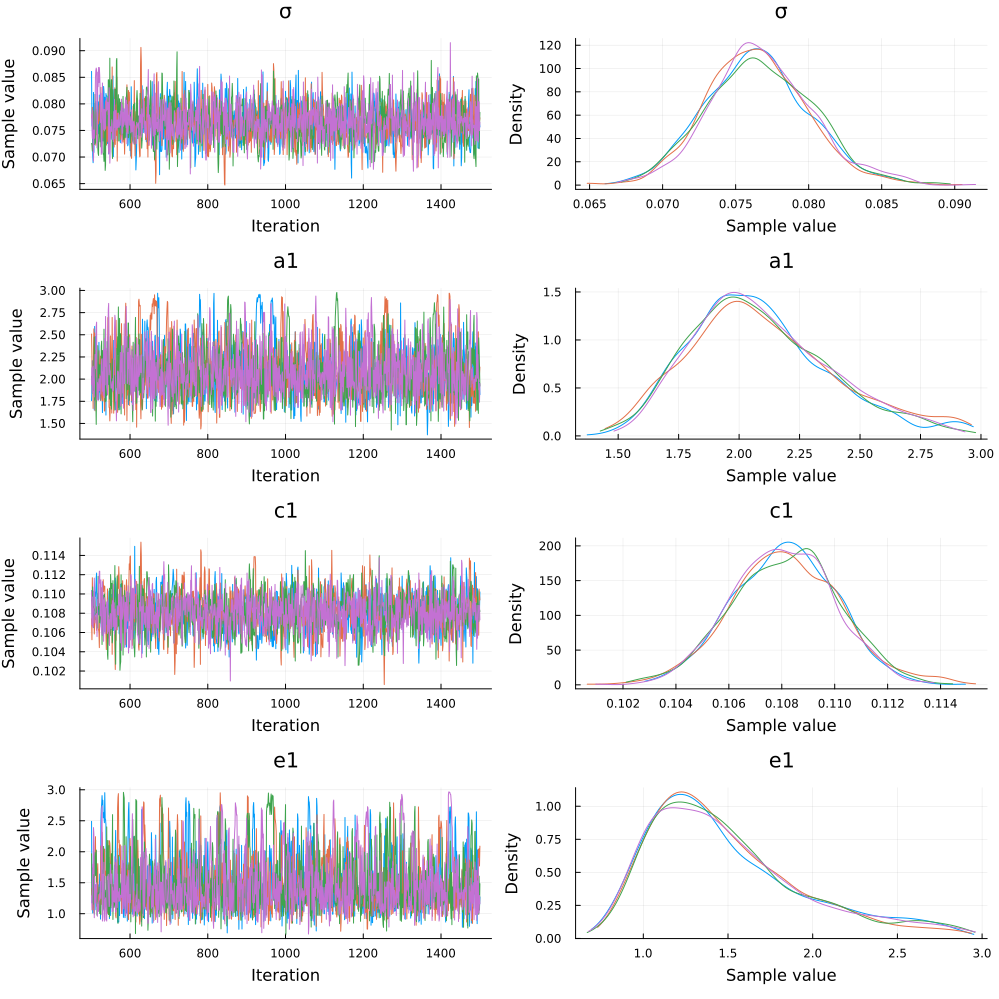

In [9]:
plot(chain)